In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
# загружаем данные и разбиваем их на составляющие
train = pd.read_csv("./train.csv")
y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

In [3]:

X_train = normalize(X_train.astype('float32'), axis=1)

# Из файла информацию о изображения с цифрами мы получили в виде одномерных векторов из 784 значений
# Переформируем все данные в трехмерные матрицы 28x28x1.
# Keras требует дополнительное измерение в конце, для каналов. 
# Если бы это были RGB-изображения, то было бы 3 канала, но поскольку у нас "черно-белое" изображение, мы указываем 1 серый канал.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

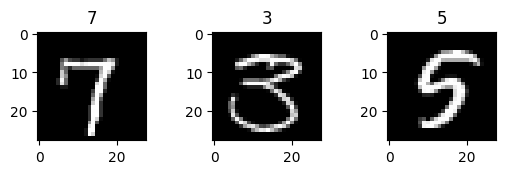

In [4]:
# убедимся, что все ок, выведем сами тестовые изображения и соответствующие им цифры 
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

In [5]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

# Нормализуем данные
def normalize(x): 
    return (x-mean_px)/std_px

Метки в данном случае представлены целыми числами от 0 до 9. 
Нам нужно применить one-hot encoding, чтобы преобразовать эти one-hot числовой массив (например: 2 -> [0,0,1,0,0,0,0,0,0,0,0]).

In [6]:
print(f"{y_train[0]} преобрауется в ")
y_train = to_categorical(y_train, num_classes = 10)
# Пример:
print(y_train[0])

1 преобрауется в 
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

In [8]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)


In [9]:
model = Sequential()
model.add(Lambda(normalize,input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu')),
model.add(Dense(128, activation='relu')),
model.add(Dense(10, activation='softmax'))

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Определим callback для сохранения весов на каждой этапе обучения
# Это понадобится позже для определения параметров, при которых точность максимальна
checkpoint_callback = ModelCheckpoint(
    filepath='weights.{epoch:02d}.h5',
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)

history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=30, 
                    verbose=1,
                    validation_data=(X_test, y_test), callbacks=[checkpoint_callback])

loss, accuracy = model.evaluate(X_test, y_test)

print(f"Final loss: {loss}")
print(f"Final accuracy: {accuracy}")


Epoch 1/30


2094/2100 [============================>.] - ETA: 0s - loss: 0.4858 - accuracy: 0.8449
Epoch 1: saving model to weights.01.h5
2100/2100 [==============================] - 14s 6ms/step - loss: 0.4857 - accuracy: 0.8449 - val_loss: 0.2196 - val_accuracy: 0.9325
Epoch 2/30
2092/2100 [============================>.] - ETA: 0s - loss: 0.2565 - accuracy: 0.9204
Epoch 2: saving model to weights.02.h5
2100/2100 [==============================] - 13s 6ms/step - loss: 0.2569 - accuracy: 0.9203 - val_loss: 0.1579 - val_accuracy: 0.9520
Epoch 3/30
2092/2100 [============================>.] - ETA: 0s - loss: 0.2120 - accuracy: 0.9341
Epoch 3: saving model to weights.03.h5
2100/2100 [==============================] - 12s 6ms/step - loss: 0.2120 - accuracy: 0.9342 - val_loss: 0.1313 - val_accuracy: 0.9582
Epoch 4/30
2095/2100 [============================>.] - ETA: 0s - loss: 0.1912 - accuracy: 0.9424
Epoch 4: saving model to weights.04.h5
2100/2100 [==============================] - 13s

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Посмотрим, как происходило изменение точности на каждой из эпох

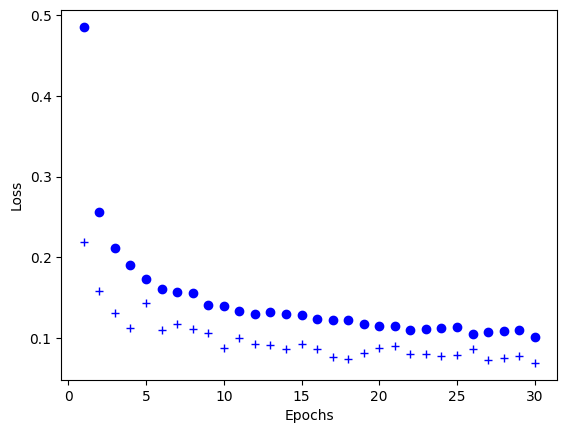

In [13]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

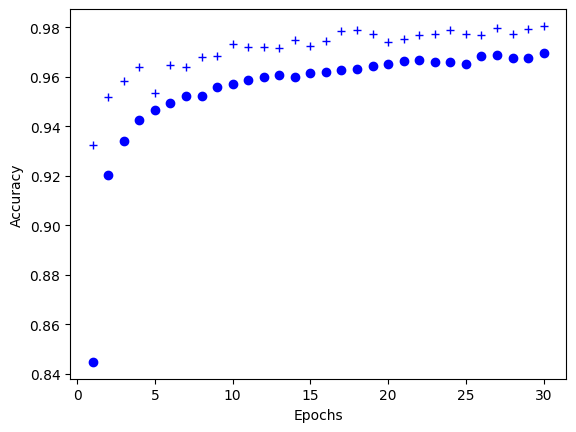

In [14]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

### градиент целевой функции по обучаемым параметрам нейронной сети

In [15]:
# Calculate gradients using tf.GradientTape
with tf.GradientTape() as tape:
    y_pred = model(X_test)
    loss_value = tf.keras.losses.categorical_crossentropy(y_test, y_pred)

# Calculate gradients of loss with respect to model trainable variables
gradients = tape.gradient(loss_value, model.trainable_variables)

# Print the gradients
for var, grad in zip(model.trainable_variables, gradients):
    print(f"Variable: {var.name}, Gradient shape: {grad.shape}")
    print(grad.numpy())

Variable: dense/kernel:0, Gradient shape: (784, 128)
[[-0.29921213  0.25556448  0.12005004 ...  0.0126336   0.08858687
   2.0859957 ]
 [-0.29921213  0.25556448  0.12005004 ...  0.0126336   0.08858687
   2.0859957 ]
 [-0.29921213  0.25556448  0.12005004 ...  0.0126336   0.08858687
   2.0859957 ]
 ...
 [-0.29921213  0.25556448  0.12005004 ...  0.0126336   0.08858687
   2.0859957 ]
 [-0.29921213  0.25556448  0.12005004 ...  0.0126336   0.08858687
   2.0859957 ]
 [-0.29921213  0.25556448  0.12005004 ...  0.0126336   0.08858687
   2.0859957 ]]
Variable: dense/bias:0, Gradient shape: (128,)
[ 7.13735044e-01 -6.09619021e-01 -2.86365181e-01 -1.10437766e-01
 -5.20209856e-02 -4.23281789e-01  3.58179659e-02 -1.24476874e+00
 -8.83171678e-01  1.00791514e+00  1.50097713e-01 -9.22842383e-01
  3.42850542e+00 -1.60067189e+00 -1.14543581e+00  4.38364804e-01
  2.78165728e-01  1.43971455e+00 -3.47272485e-01  9.12820041e-01
  1.75243258e+00 -1.65582031e-01 -4.60704774e-01  1.57802477e-01
  4.18224782e-01  

### параметры нейронной сети, при которых точность классификации максимальна

Чтобы определить параметры нейронной сети, при которых точность классификации максимальна, мы
- должны проанализировать объект history, возвращаемый методом fit(), который содержит историю обучения, включая значения точности для каждой эпохи;
- найти эпоху с лучшей точностью проверки;
- по мере обучения модели мы сохраняем веса, полученные на каждой эпохе, в отдельный файл. Загрузим веса из файла соответсвующего эпохе с лучшей точностью;
- используем model.get_weights() для получения параметров (весов и смещений) модели в лучшую эпоху. Мы перебираем параметры и выводим их формы, чтобы проверить размеры параметров каждого слоя.

In [19]:
# Найдем эпоху с наивысшей точностью валидации
best_epoch = np.argmax(history.history['val_accuracy'])
best_accuracy = history.history['val_accuracy'][best_epoch]

# Получим веса модели для этой эпохи из файла, сохраненного ранее на этапе обучения
model.load_weights(f'weights.{best_epoch+1:02d}.h5')

# Получим параметры модели для лучшей эпохи
best_parameters = model.get_weights()

print(f"Best accuracy: {best_accuracy}")
print("Best params:")
for layer_param in best_parameters:
    print(layer_param)

Best accuracy: 0.9805952310562134
Best params:
[[ 0.02949593 -0.04756884  0.00404331 ...  0.05892873  0.129211
   0.07234291]
 [-0.09087019 -0.04386     0.06456129 ...  0.00464164  0.06734035
   0.0281317 ]
 [-0.05514572 -0.06834882  0.11618973 ... -0.00348602  0.13242157
   0.07790106]
 ...
 [-0.07552447  0.04208294  0.00145352 ...  0.09313285  0.14105581
   0.1064895 ]
 [-0.02187575 -0.00207477  0.10021647 ...  0.0793252   0.13528548
  -0.02516678]
 [-0.09682751 -0.0620464   0.12633984 ...  0.00977407  0.04720979
   0.04855281]]
[ 0.02926639 -0.00582684 -0.07992987 -0.0908727  -0.11511593 -0.06966219
 -0.17794554 -0.03058179 -0.10369933 -0.13052994 -0.15256411 -0.05453183
 -0.10126723 -0.12297083 -0.17858282 -0.04025977 -0.14477065 -0.18011345
 -0.11113274 -0.1603664  -0.13715777  0.07525317 -0.1415084  -0.16506343
 -0.06396738 -0.12866983 -0.03497632 -0.04125307 -0.04695872 -0.1196413
 -0.16622911 -0.16918865 -0.14449722 -0.15156667 -0.11330795 -0.14568889
 -0.03250709 -0.12432967  

In [18]:
print("Описание модели:")
model.summary()

Описание модели:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 28, 28, 1)         0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118282 (462.04 KB)
Trainable params: 118282 (462.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________